# Background Story

Kamu adalah seorang Data Scientist di Kalbe Nutritionals dan sedang mendapatkan project baru dari tim inventory dan tim marketing.

**Dari tim inventory**
Kamu diminta untuk dapat membantu memprediksi jumlah penjualan (quantity) dari total keseluruhan product Kalbe
1. Tujuan dari project ini adalah untuk mengetahui perkiraan quantity product yang terjual sehingga tim inventory dapat membuat stock persediaan harian yang cukup.
2. Prediksi yang dilakukan harus harian.

**Dari tim marketing**
Kamu diminta untuk membuat cluster/segment customer berdasarkan beberapa kriteria.
1. Tujuan dari project ini adalah untuk membuat segment customer.
2. Segment customer ini nantinya akan digunakan oleh tim marketing untuk memberikan personalized promotion dan sales treatment.

# Import Library

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load Dataset

In [6]:
customer = pd.read_csv('Data/Data Bersih(SQL)/Customer.csv')
product = pd.read_csv('Data/Data Bersih(SQL)/Product.csv')
store = pd.read_csv('Data/Data Bersih(SQL)/Store.csv')
transaction = pd.read_csv('Data/Data Bersih(SQL)/Transaction.csv')

In [7]:
customer.head()

,CustomerID,Age,Gender,MaritalStatus,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57


In [8]:
product.head()

,ProductID,ProductName,Price
0,P1,Choco Bar,8800
1,P10,Cheese Stick,15000
2,P2,Ginger Candy,3200
3,P3,Crackers,7500
4,P4,Potato Chip,12000


In [9]:
store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.20000,106.817
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.91486,107.608
2,3,Prima Kota,Prima,Modern Trade,-7.79707,110.371
3,4,Gita Ginara,Gita,General Trade,-6.96667,110.417
4,5,Bonafid,Gita,General Trade,-7.25044,112.769


In [10]:
transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Sequence
0,TR67501,85,2022-01-08,P4,12000,3,36000,13,1
1,TR21798,83,2022-02-10,P9,10000,5,50000,11,2
2,TR11369,328,2022-01-01,P3,7500,4,30000,12,3
3,TR70157,415,2022-01-08,P8,16000,2,32000,4,4
4,TR84962,55,2022-01-08,P3,7500,5,37500,7,5


# Deskripsi Data

Dataset ini terdiri dari 4 csv file yaitu customer, store, product dan transaction.
Merupakan dummy data untuk studi kasus FMCG dalam kurun waktu 1 tahun yang diambil melalui program membership.

Penjelasan 
1. Customer
- CustomerID : No Unik Customer
- Age : Usia Customer
- Gender : 0 Wanita, 1 Pria
- Marital Status : Married, Single (Blm menikah/Pernah menikah)
- Income : Pendapatan per bulan dalam jutaan rupiah

2. Store
- StoreID : Kode Unik Store
- StoreName : Nama Toko
- GroupStore : Nama group
- Type : Modern Trade, General Trade
- Latitude : Kode Latitude
- Longitude : Kode Longitude

3. Product
- ProductID : Kode Unik Product
- Product Name : Nama Product
- Price : Harga dlm rupiah

4. Transaction
- TransactionID : Kode Unik Transaksi
- Date : Tanggal transaksi
- Qty : Jumlah item yang dibeli
- Total Amount : Price x Qty

# Cek Anomali Data

In [11]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     441 non-null    int64  
 1   Age            441 non-null    int64  
 2   Gender         441 non-null    int64  
 3   MaritalStatus  441 non-null    object 
 4   Income         441 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 17.4+ KB


In [12]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StoreID     14 non-null     int64  
 1   StoreName   14 non-null     object 
 2   GroupStore  14 non-null     object 
 3   Type        14 non-null     object 
 4   Latitude    14 non-null     float64
 5   Longitude   14 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 800.0+ bytes


In [13]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ProductID    10 non-null     object
 1   ProductName  10 non-null     object
 2   Price        10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [14]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
 8   Sequence       5020 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 353.1+ KB


ubah data pada date menjadi DateTime

In [15]:
transaction['Date'] = pd.to_datetime(transaction['Date'])

In [16]:
duplikat_customer = customer.duplicated().sum()
print('Data duplikat pada Customer ada sebanyak', duplikat_customer)

duplikat_product = product.duplicated().sum()
print('Data duplikat pada Product ada sebanyak', duplikat_product)

duplikat_store = store.duplicated().sum()
print('Data duplikat pada Store ada sebanyak', duplikat_store)
    
duplikat_transaksi = transaction.duplicated().sum()
print('Data duplikat pada Store ada sebanyak', duplikat_transaksi)

Data duplikat pada Customer ada sebanyak 0
Data duplikat pada Product ada sebanyak 0
Data duplikat pada Store ada sebanyak 0
Data duplikat pada Store ada sebanyak 0


In [17]:
customer.describe()

,CustomerID,Age,Gender,Income
count,441.000000,441.000000,441.000000,441.000000
mean,224.591837,40.099773,0.451247,8.633016
std,128.234626,12.520856,0.498183,6.638645
min,1.000000,18.000000,0.000000,0.000000
25%,114.000000,31.000000,0.000000,4.180000
50%,225.000000,39.000000,0.000000,7.550000
75%,335.000000,51.000000,1.000000,10.860000
max,447.000000,72.000000,1.000000,71.300000


In [18]:
product.describe()

,Price
count,10.000000
mean,10410.000000
std,4890.455557
min,3200.000000
25%,7825.000000
50%,9700.000000
75%,14250.000000
max,18000.000000


In [19]:
store.describe()

,StoreID,Latitude,Longitude
count,14.0000,14.000000,14.000000
mean,7.5000,-2.902408,109.463236
std,4.1833,4.516743,8.654846
min,1.0000,-7.797070,95.323800
25%,4.2500,-6.736145,104.884500
50%,7.5000,-4.395050,108.989500
75%,10.7500,0.082839,114.134750
max,14.0000,5.548290,128.191000


In [20]:
transaction.describe()

,CustomerID,Date,Price,Qty,TotalAmount,StoreID,Sequence
count,5020.000000,5020,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000
mean,221.263745,2022-06-29 00:32:24.860557824,9684.800797,3.644622,32279.482072,7.489841,2510.500000
min,1.000000,2022-01-01 00:00:00,3200.000000,1.000000,7500.000000,1.000000,1.000000
25%,108.000000,2022-03-30 00:00:00,4200.000000,2.000000,16000.000000,4.000000,1255.750000
50%,221.000000,2022-06-26 00:00:00,9400.000000,3.000000,28200.000000,7.000000,2510.500000
75%,332.000000,2022-09-28 00:00:00,15000.000000,5.000000,47000.000000,11.000000,3765.250000
max,447.000000,2022-12-31 00:00:00,18000.000000,10.000000,88000.000000,14.000000,5020.000000
std,129.672955,NaN,4600.708780,1.855295,19675.462455,4.028502,1449.293506


# Merge Data

In [21]:
df_merge = pd.merge(transaction, customer, on='CustomerID', how='inner')
df_merge = pd.merge(df_merge, product.drop(columns=('Price')), on='ProductID', how='inner')
df_merge = pd.merge(df_merge, store, on='StoreID', how='inner')

In [22]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Sequence,Age,Gender,MaritalStatus,Income,ProductName,StoreName,GroupStore,Type,Latitude,Longitude
0,TR67501,85,2022-01-08,P4,12000,3,36000,13,1,59,1,Married,7.89,Potato Chip,Buana,Buana,General Trade,-1.26916,116.825
1,TR578,55,2022-07-15,P4,12000,1,12000,13,2898,34,1,Married,8.44,Potato Chip,Buana,Buana,General Trade,-1.26916,116.825
2,TR10955,222,2022-05-23,P4,12000,1,12000,13,2025,45,0,Married,15.03,Potato Chip,Buana,Buana,General Trade,-1.26916,116.825
3,TR70238,23,2022-04-14,P4,12000,2,24000,13,1178,57,1,Married,12.56,Potato Chip,Buana,Buana,General Trade,-1.26916,116.825
4,TR3631,168,2022-07-12,P4,12000,3,36000,13,2817,27,0,Married,4.88,Potato Chip,Buana,Buana,General Trade,-1.26916,116.825


In [23]:
df_merge.to_csv("Data/Data Bersih(SQL)/~DataMart.csv")

# Exploritori Data Analyst and Visualisasi

In [24]:
# buat dataframe baru
df = df_merge.groupby('Date')['Qty'].sum().reset_index()
df.head()

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,28


In [25]:
#Set Date sebagai index
df.set_index('Date', inplace=True)
df.head()

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,28


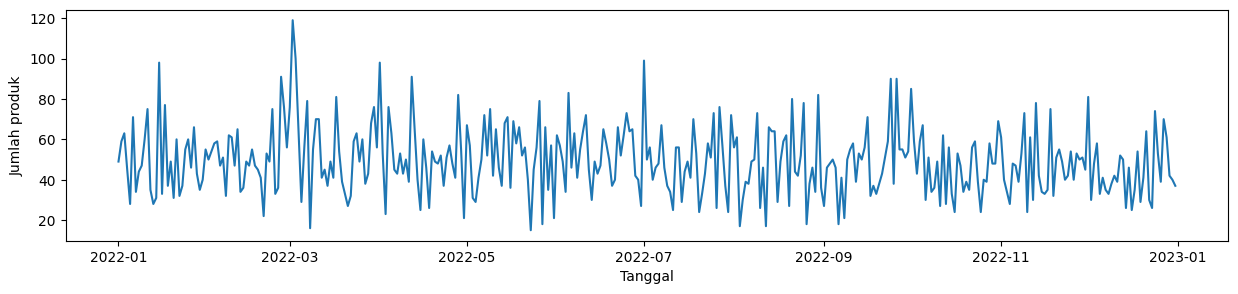

In [26]:
# melihat stasionari dari data
plt.figure(figsize=(15,3))
plt.xlabel('Tanggal')
plt.ylabel('Jumlah produk')
plt.plot(df)

Menampilkan grafik produk dari 01/2022 s.d 12/2022. Dimana data tersebut bersifat berulang.

# Cek Stasionary

 hasil uji Augmented Dickey-Fuller (ADF) gunanya untuk memeriksa apakah data deret waktu bersifat stasioner

In [27]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')

    print("1. ADF :", dftest[0])
    print("2. P-Value :", dftest[1])
    print("3. Num of Lags :", dftest[2])
    print("4. Num of Observation used for ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values:")
    for key, val in dftest[4].items():
        print("\t", key, ":", val)

ad_test(df['Qty'])

1. ADF : -19.11935492108116
2. P-Value : 0.0
3. Num of Lags : 0
4. Num of Observation used for ADF Regression and Critical Values Calculation : 364
5. Critical Values:
	 1% : -3.4484434475193777
	 5% : -2.869513170510808
	 10% : -2.571017574266393


Secara keseluruhan, hasil ini menunjukkan bahwa data deret waktu bersifat stasioner, seperti yang ditunjukkan oleh nilai p yang sangat rendah dan statistik ADF yang lebih negatif daripada nilai kritis pada berbagai tingkat signifikansi.

In [28]:
stepwise_fit = auto_arima(df['Qty'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3340.912, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3236.063, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3338.913, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3198.932, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3155.784, Time=0.29 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3149.738, Time=0.63 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3134.015, Time=0.49 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=3132.022, Time=0.36 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3147.744, Time=0.27 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3094.246, Time=0.88 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3092.755, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -1540.377
Date:                Thu, 19 Oct 2023   AIC                           3092.755
Time:                        16:08:48   BIC                           3116.138
Sample:                    01-01-2022   HQIC                          3102.049
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0172      0.048     -0.359      0.720      -0.111       0.077
ar.L2         -0.0103      0.052     -0.198      0.843      -0.112       0.092
ar.L3         -0.0323      0.051     -0.632      0.527      -0.133       0.068
ar.L4          0.1015      0.052      1.937      0.053      -0.001       0.204
ma.L1         -0.9860      0.013    -76.164      0.000      -1.011      -0.961
sigma2       274.7839     20.460     13.430      0.000     234.683     314.885
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                22.48
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.55
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Best model:  ARIMA(4,1,1)(0,0,0)[0]

# Split Data

In [29]:
print(df.shape)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
print('Train', train.shape)
print('Test', test.shape)

(365, 1)
Train (292, 1)
Test (73, 1)


# Train Model

In [30]:
from statsmodels.tsa.arima.model import ARIMA

# Mengganti baris kode model ARIMA
model = ARIMA(train['Qty'], order=(4, 1, 1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Qty   No. Observations:                  292
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -1241.721
Date:                Thu, 19 Oct 2023   AIC                           2495.442
Time:                        16:08:49   BIC                           2517.482
Sample:                    01-01-2022   HQIC                          2504.271
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0051      0.054      0.096      0.924      -0.100       0.110
ar.L2         -0.0021      0.058     -0.037      0.971      -0.116       0.112
ar.L3         -0.0511      0.059     -0.866      0.387      -0.167       0.065
ar.L4          0.1257      0.059      2.128      0.033       0.010       0.242
ma.L1         -0.9911      0.016    -60.432      0.000      -1.023      -0.959
sigma2       293.7263     24.711     11.886      0.000     245.294     342.159
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.61
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.52
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Membuat prediksi di test set

In [31]:
start = len(train)
end = len(train)+len(test)-1
pred = model.predict(start=start, end=end, type='levels')

pred.index = df.index[start:end+1]
print(pred)

Date
2022-10-20    45.766021
2022-10-21    49.807276
2022-10-22    49.712249
2022-10-23    47.467708
2022-10-24    48.729608
                ...    
2022-12-27    49.202641
2022-12-28    49.202641
2022-12-29    49.202641
2022-12-30    49.202641
2022-12-31    49.202641
Name: predicted_mean, Length: 73, dtype: float64


<Axes: xlabel='Date'>

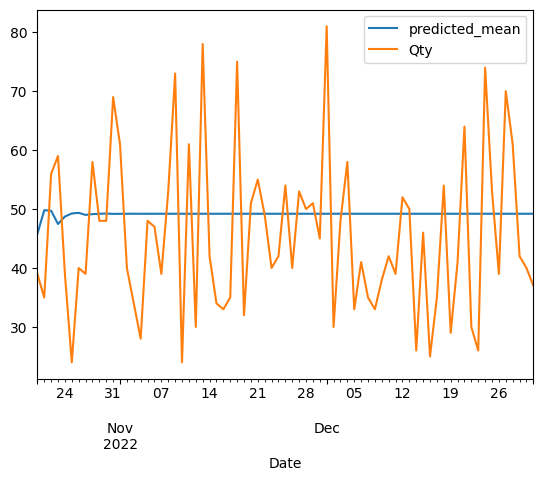

In [32]:
pred.plot(legend=True)
test['Qty'].plot(legend=True)

In [33]:
test['Qty'].mean()

45.52054794520548

# Evaluasi Model

In [34]:
print(test.shape, pred.shape)

(73, 1) (73,)


In [35]:
RMSE = sqrt(mean_squared_error(test, pred))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 14.103


# Hasil Prediksi

In [36]:
model2 = ARIMA(df['Qty'], order=(4,1,1))
model2 = model2.fit()
df.tail()

,Qty
Date,
2022-12-27,70
2022-12-28,61
2022-12-29,42
2022-12-30,40
2022-12-31,37


Cek hasil prediksi

In [40]:
index_future_dates = pd.date_range(start='2022-12-31', end='2023-01-31')
pred = model2.predict(start=len(df), end=len(df)+31, type='level').rename('ARIMA PREDICTION')
pred.index = index_future_dates
pred

2022-12-31    48.380764
2023-01-01    46.351270
2023-01-02    46.163133
2023-01-03    45.514522
2023-01-04    46.748773
2023-01-05    46.534222
2023-01-06    46.527100
2023-01-07    46.423651
2023-01-08    46.557760
2023-01-09    46.534962
2023-01-10    46.536598
2023-01-11    46.521963
2023-01-12    46.536552
2023-01-13    46.534084
2023-01-14    46.534616
2023-01-15    46.532674
2023-01-16    46.534263
2023-01-17    46.533988
2023-01-18    46.534093
2023-01-19    46.533846
2023-01-20    46.534019
2023-01-21    46.533988
2023-01-22    46.534005
2023-01-23    46.533974
2023-01-24    46.533993
2023-01-25    46.533989
2023-01-26    46.533992
2023-01-27    46.533988
2023-01-28    46.533990
2023-01-29    46.533990
2023-01-30    46.533990
2023-01-31    46.533990
Freq: D, Name: ARIMA PREDICTION, dtype: float64

<Axes: >

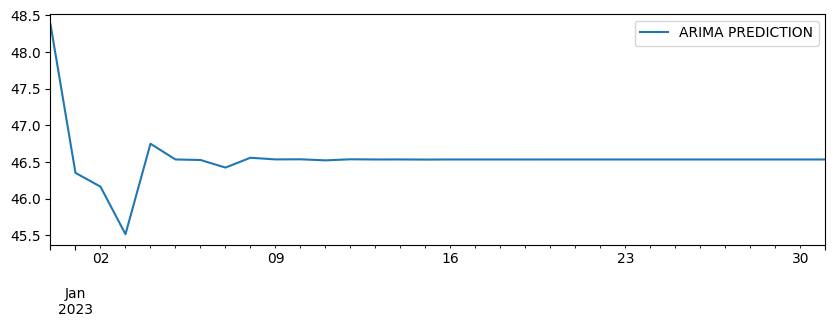

In [38]:
pred.plot(figsize=(10,3), legend=True)

In [39]:
pred.to_csv("Data/Data Bersih(SQL)/~Hasil_prediski.csv")